# Building the Model

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

pd.options.display.float_format = '{:.4f}'.format
import statsmodels.api as sm

**For this model I analayzed the heatmap/ correlations ofnumeric columns with sale price and the catterplots/ bargraphs of the categorical columns and sale price. I will start witha model with just these variables and then use stepwise regression to add and drop variables**

In [265]:
clean_data = pd.read_csv('datasets/clean_df.csv')

In [266]:
clean_data.dtypes

Unnamed: 0      int64
Id              int64
PID             int64
MS SubClass     int64
MS Zoning      object
                ...  
Misc Val        int64
Mo Sold         int64
Yr Sold         int64
Sale Type      object
SalePrice       int64
Length: 82, dtype: object

In [267]:
clean_data['MS SubClass'] = clean_data['MS SubClass'].astype(str)

In [268]:
Columns_to_include = ['SalePrice', 
                      'Overall Qual', 
                      'Gr Liv Area', 
                      'Garage Area', 
                      'Garage Cars', 
                      'Total Bsmt SF', 
                      '1st Flr SF', 
                      'Year Built', 
                      'Full Bath', 
                      'Fireplaces', 
                      'MS SubClass', 
                      'Neighborhood', 
                      'Condition 1', 
                      'Exter Qual', 
                      'Bsmt Exposure', 
                      'Kitchen Qual', 
                      'Garage Qual',
                      'Exterior 1st',
                      'Exter Cond',
                      'Bsmt Qual',
                      'Bsmt Cond',
                      'BsmtFin Type 1',
                      'Functional',
                      'Fireplace Qu',
                      'Paved Drive',
                      'Sale Type',
                      'Garage Cond']

In [269]:
clean_columns = clean_data[Columns_to_include]

In [270]:
#Confirm Data is fully cleaned- this is the step I will repeat on Test Data
# Create a list of string-type column names
string_columns = clean_data.select_dtypes(include=['object']).columns

column_to_exclude = 'Mas Vnr Type'

# Use a for loop to input NA in each column in dataframe that is in list except Mas Vnr Type
for column in string_columns:
    if column != column_to_exclude:
        clean_data[column].fillna('NA', inplace=True)

In [271]:
X1 = clean_data[Columns_to_include].drop(columns='SalePrice')
y = clean_data['SalePrice']

In [272]:
X1['Garage Qual'].value_counts()

TA    1832
NA     114
Fa      82
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64

In [273]:
y.shape

(2051,)

In [274]:
X1_train, X1_val, y_train, y_val = train_test_split(X1, y, test_size= 0.2, random_state=24)

In [275]:
# First I will create a baseline
base_preds = [clean_data['SalePrice'].mean()] * len(y_val)

# MSE
base_mse = mean_squared_error(y_val, base_preds)
base_mse


5959496572.987543

In [276]:
# For the Baseline I expect R 2 to be about 0
r2_score(y_val, base_preds)

-1.9433919757450013e-05

In [277]:
X1_str = list(X1.select_dtypes(include=['object']).columns)

*Credit to Qingxin Wei who suggested using handle_unknown='ignore'*

In [278]:
# I use a OneHot Encoder with argument handle_unknown = 'ignore' to binarize my column & handle new values
ct = ColumnTransformer([('oh', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), X1_str)
], remainder='passthrough')  

# Fit and transform the training data using the ColumnTransformer
X1_train_transformed = ct.fit_transform(X1_train)

# Transform the test data using the fitted ColumnTransformer
X1_val_transformed = ct.transform(X1_val)


# Use a simpleImputer since numeric missings were filled with Np.nan during cleaning
imputer = SimpleImputer(strategy='median')
X1_train_transformed = imputer.fit_transform(X1_train_transformed)
X1_val_transofrmed = imputer.transform(X1_val_transformed)


In [279]:
lr=LinearRegression()

In [280]:
lr.fit(X1_train_transformed, y_train)

LinearRegression()

In [281]:
r2_train = lr.score(X1_train_transformed, y_train)
r2_val = lr.score(X1_val_transformed, y_val)
print(r2_train)
print(r2_val)

0.8911281372375199
0.9079038541824045


In [282]:
y_preds_train = lr.predict(X1_train_transformed)
metrics.mean_squared_error(y_train, y_preds_train)

692305679.6847442

In [283]:
y_preds_val = lr.predict(X1_val_transformed)
metrics.mean_squared_error(y_val, y_preds_val)

548835999.35055

In [284]:
lr.coef_

array([-8.17489394e+04, -1.17396240e+04, -9.47369820e+03,  1.99859603e+04,
        3.74371324e+04,  3.93228633e+04,  3.52486374e+04,  4.32640696e+04,
        3.39502016e+04,  2.44717695e+04,  3.60313480e+04,  4.44433884e+04,
        2.31684475e+04,  2.89114936e+04,  1.28507351e+04, -3.54929607e+03,
        1.36207512e+04, -1.44471300e+04,  1.28085802e+04, -5.35905635e+03,
        1.24459170e+04, -1.96863785e+04, -7.28906681e+03,  9.04832218e+03,
        1.28218030e+05, -1.82807028e+04,  1.47555654e+03, -4.98676995e+03,
       -7.55327074e+03, -1.04172574e+04,  4.99366582e+03, -6.83629209e+03,
        4.54325893e+04,  3.38811278e+04, -2.10246211e+04, -1.44861954e+04,
       -7.66299592e+03, -4.90568593e+03,  1.23465178e+04,  5.61668345e+04,
        1.11416386e+03,  8.33802923e+03,  3.37061715e+03,  1.30060760e+04,
        2.83608543e+04,  2.48648575e+04, -5.75319073e+03,  1.15913414e+04,
       -6.38299847e+03,  4.90202704e+03, -3.23254787e+04, -2.39570107e+04,
       -2.84102373e+04,  

*Credit to Susan for add_constant to simplify creating an intercept process*

In [285]:
ols = sm.OLS(y_train, sm.add_constant(X1_train_transformed)).fit()
summary_table = ols.summary()
summary_table

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     93.45
Date:                Fri, 06 Oct 2023   Prob (F-statistic):               0.00
Time:                        07:33:59   Log-Likelihood:                -19019.
No. Observations:                1640   AIC:                         3.830e+04
Df Residuals:                    1507   BIC:                         3.902e+04
Df Model:                         132                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.091e+05   1.61e+05     -1.922      0.055   -6.25e+05    6366.143
x1         -8.175e+04   3.07e+04     -2.662      0.008   -1.42e+05   -2.15e+04
x2         -1.174e+04   6182.553     -1.899      0.058   -2.39e+04     387.697
x3         -9473.6982   1.11e+04     -0.856      0.392   -3.12e+04    1.22e+04
x4          1.999e+04   7109.938      2.811      0.005    6039.536    3.39e+04
x5          3.744e+04   3786.214      9.888      0.000       3e+04    4.49e+04
x6          3.932e+04   5983.711      6.572      0.000    2.76e+04    5.11e+04
x7          3.525e+04   2.86e+04      1.234      0.217   -2.08e+04    9.13e+04
x8          4.326e+04   1.25e+04      3.452      0.001    1.87e+04    6.78e+04
x9          3.395e+04   5668.867      5.989      0.000    2.28e+04    4.51e+04
x10         2.447e+04   5364.877      4.561      0.000    1.39e+04     3.5e+04
x11         3.603e+04   6877.648      5.239      0.000    2.25e+04    4.95e+04
x12         4.444e+04   1.14e+04      3.886      0.000     2.2e+04    6.69e+04
x13         2.317e+04   5246.229      4.416      0.000    1.29e+04    3.35e+04
x14         2.891e+04   8336.370      3.468      0.001    1.26e+04    4.53e+04
x15         1.285e+04   6101.490      2.106      0.035     882.423    2.48e+04
x16        -3549.2961   1.49e+04     -0.238      0.812   -3.28e+04    2.57e+04
x17         1.362e+04   1.21e+04      1.124      0.261   -1.01e+04    3.74e+04
x18        -1.445e+04   9616.937     -1.502      0.133   -3.33e+04    4416.872
x19         1.281e+04   1.13e+04      1.130      0.259   -9435.300    3.51e+04
x20        -5359.0563   8259.510     -0.649      0.517   -2.16e+04    1.08e+04
x21         1.245e+04   9128.126      1.363      0.173   -5459.261    3.04e+04
x22        -1.969e+04   8883.694     -2.216      0.027   -3.71e+04   -2260.662
x23        -7289.0668   8480.541     -0.860      0.390   -2.39e+04    9345.849
x24         9048.3222   2.13e+04      0.425      0.671   -3.27e+04    5.08e+04
x25         1.282e+05   2.12e+04      6.051      0.000    8.67e+04     1.7e+05
x26        -1.828e+04   9790.320     -1.867      0.062   -3.75e+04     923.395
x27         1475.5565   2.91e+04      0.051      0.960   -5.55e+04    5.85e+04
x28        -4986.7700   1.22e+04     -0.410      0.682   -2.89e+04    1.89e+04
x29        -7553.2707   8847.902     -0.854      0.393   -2.49e+04    9802.237
x30        -1.042e+04   8693.235     -1.198      0.231   -2.75e+04    6634.866
x31         4993.6658   1.13e+04      0.441      0.659   -1.72e+04    2.72e+04
x32        -6836.2921   8981.693     -0.761      0.447   -2.45e+04    1.08e+04
x33         4.543e+04   9470.375      4.797      0.000    2.69e+04     6.4e+04
x34         3.388e+04   8318.445      4.073      0.000    1.76e+04    5.02e+04
x35        -2.102e+04   9290.228     -2.263      0.024   -3.92e+04   -2801.473
x3

In [286]:
ct.get_feature_names_out()

array(['oh__MS SubClass_150', 'oh__MS SubClass_160',
       'oh__MS SubClass_180', 'oh__MS SubClass_190', 'oh__MS SubClass_20',
       'oh__MS SubClass_30', 'oh__MS SubClass_40', 'oh__MS SubClass_45',
       'oh__MS SubClass_50', 'oh__MS SubClass_60', 'oh__MS SubClass_70',
       'oh__MS SubClass_75', 'oh__MS SubClass_80', 'oh__MS SubClass_85',
       'oh__MS SubClass_90', 'oh__Neighborhood_Blueste',
       'oh__Neighborhood_BrDale', 'oh__Neighborhood_BrkSide',
       'oh__Neighborhood_ClearCr', 'oh__Neighborhood_CollgCr',
       'oh__Neighborhood_Crawfor', 'oh__Neighborhood_Edwards',
       'oh__Neighborhood_Gilbert', 'oh__Neighborhood_Greens',
       'oh__Neighborhood_GrnHill', 'oh__Neighborhood_IDOTRR',
       'oh__Neighborhood_Landmrk', 'oh__Neighborhood_MeadowV',
       'oh__Neighborhood_Mitchel', 'oh__Neighborhood_NAmes',
       'oh__Neighborhood_NPkVill', 'oh__Neighborhood_NWAmes',
       'oh__Neighborhood_NoRidge', 'oh__Neighborhood_NridgHt',
       'oh__Neighborhood_OldTown', 

### Coefficient Interpretations:

- MS SubClass or house type is a signficcant predictor. The baseline is 1- Story Planned Unit Development. Holding all other variables equal, out of all PUDs, the 1 story models have the highest sale prices: changing from a 1-story to a 1 1/2 story (while holding all else equal) decreases the predicted price by \$81,750. 
- All else held equal, adding a fireplace increasese the home value by over \$7,000
- All else held equal, adding a bathroom increases the home value by \$5,550.
- Basements only slightly improved the value: the home value increased by 4 for every increase in sq footage of the basement when all else was held equal
- Holding all else equal, adding a garage and increasing the size increased the home value. Creating space for one more car resulted in an approximatedly \$10,000 increased in value
- Quality of the house and materials mattered: increasing the overall quality of the house by 1 led to an increase in sale price of almost \$8,000

In [287]:
test = pd.read_csv('datasets/test.csv')

In [288]:
test['MS SubClass'] = test['MS SubClass'].astype(str)

In [289]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    object 
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [290]:
#For the columns I am using, the solution for missing values was to fill na with 
test.fillna('NA', inplace=True)

In [291]:
test_columns = ['Overall Qual', 
                'Gr Liv Area', 
                'Garage Area', 
                'Garage Cars', 
                'Total Bsmt SF', 
                '1st Flr SF', 
                'Year Built', 
                'Full Bath', 
                'Fireplaces', 
                'MS SubClass', 
                'Neighborhood', 
                'Condition 1', 
                'Exter Qual', 
                'Bsmt Exposure', 
                'Kitchen Qual', 
                'Garage Qual',
                'Exterior 1st',
                'Exter Cond',
                'Bsmt Qual',
                'Bsmt Cond',
                'BsmtFin Type 1',
                'Functional',
                'Fireplace Qu',
                'Paved Drive',
                'Sale Type',
                'Garage Cond']
X_test = test[test_columns]

In [292]:
X_test.dtypes

Overall Qual       int64
Gr Liv Area        int64
Garage Area        int64
Garage Cars        int64
Total Bsmt SF      int64
1st Flr SF         int64
Year Built         int64
Full Bath          int64
Fireplaces         int64
MS SubClass       object
Neighborhood      object
Condition 1       object
Exter Qual        object
Bsmt Exposure     object
Kitchen Qual      object
Garage Qual       object
Exterior 1st      object
Exter Cond        object
Bsmt Qual         object
Bsmt Cond         object
BsmtFin Type 1    object
Functional        object
Fireplace Qu      object
Paved Drive       object
Sale Type         object
Garage Cond       object
dtype: object

In [293]:
#For Garage Qual & Bsmt Exposure, I can input NA for missing values as I did for training data

In [294]:

ct_full = ColumnTransformer([('oh', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), X1_str)
], remainder='passthrough')  

imputer_full = SimpleImputer(strategy='median')

In [295]:
X_transformed= ct.fit_transform(X1)
X_transformed= imputer_full.fit_transform(X_transformed)

In [296]:
lrfull= LinearRegression()
lrfull.fit(X_transformed, y)

LinearRegression()

In [297]:
np.mean(cross_val_score(lrfull, X_transformed, y))

0.8711827073220875

In [298]:
X_test_transformed = ct.transform(X_test)

C:\Users\kaitl\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [5, 7, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [299]:
saleprice = lrfull.predict(X_test_transformed)

In [300]:
saleprice.shape

(878,)

In [301]:
data = {'Id':test['Id'], 'SalePrice': saleprice}
test_sub = pd.DataFrame(data)

In [302]:
test_sub.shape

(878, 2)

In [303]:
test_sub.to_csv('datasets/submission4.csv', index=False)

### Residuals & Visualization

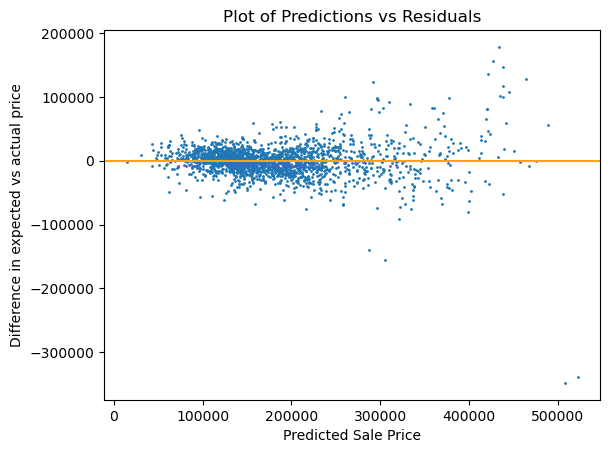

In [304]:
# Residuals are the comparison between predicted and actual prices
y_preds = lrfull.predict(X_transformed)

resids = (y - y_preds)

# Looking at a Scatterplot to check for equal variance of errors:
plt.scatter(y_preds, resids, s=1)
plt.title('Plot of Predictions vs Residuals')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Difference in expected vs actual price')
plt.axhline(0, color="orange");
plt.savefig('Resids_Scatterplot.png', dpi =500)

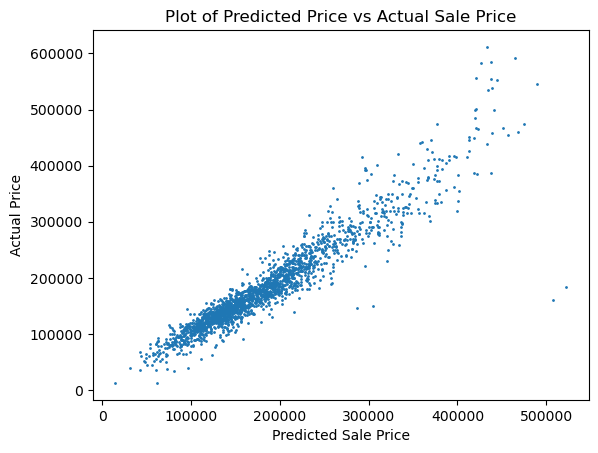

In [305]:
# Plot of Predicted vs actual
plt.scatter(y_preds, y, s=1)
plt.title('Plot of Predicted Price vs Actual Sale Price')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Price')
plt.savefig('Predicted_vs_Actual_Sale_Price.png', dpi =500)

# Analysis & Conclusions

### Model Metrics
This model performed the best out of every model I developed and tested. I analyzed the performance of this model by performing a train-test-split and then comparing the rsquared values of the training vs testing data. I also calculated and compared the MSEs. After refitting my model on the full dataset, I also calculated the cross-validation score for this model.The metrics I calculated were:
- the r squared of training data = .887 
- r squared of .905 for the validation data
- MSE of training data = 715730948.6393995 
- The MSE of validation data = 563890073.929552 
- The mean cross val score was .87

From these metrics I was able to conclude:
- The model was not overfit
- Bias may be high despite a relatively strong r2 value
-
While the validation r2 was high compared with other models, since the MSE and r2 of the validation data after the train-test split were higher than the metrics of the training data, it seems likely that there are still opportunities to reduce bias and improve the model without increasing variance and overfitting the model.

**In order to more accurately predict total revenue, this model should be refined more to better predict the Sale Price of individual homes. While an r2 of .9 is relatively high, even small improvements can mean more precise predictions which when aggragated across many homes, could translate to differences in the millions.**

# Next Steps

1. Refine the model further to better predict the Sale Price of individual homes and prevent large discrepancies in predicted vs actual revenue for IA Construction through the aggregation of errors
2. Create a model for cost based on home style/ layout, materials, room types, lot size, and time on market
3. Create a model for length of time on market
4. Utilize sale price, cost, and sale time models in a model to maximize profit per home
5. Create a final presentation for the client, IA Construction